# <font color="red">НЕТ ВОЙНЕ! - #STOPWAR <font>

### ВНИМАНИЕ!!!!
##### Поскольку github не выводит результат print(), то предпочтительно смотреть работу через nbviewer.org 
##### https://nbviewer.org/github/DmitryShuvalov/ml-intro_4_overfitting_regularization/blob/main/overfitting_regularization.ipynb

# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

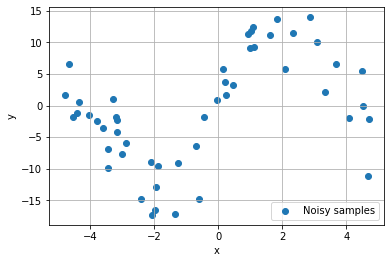

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

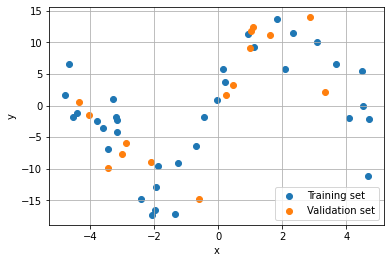

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [10]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [11]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

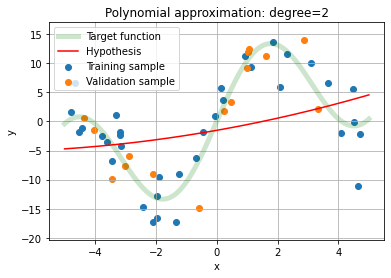

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

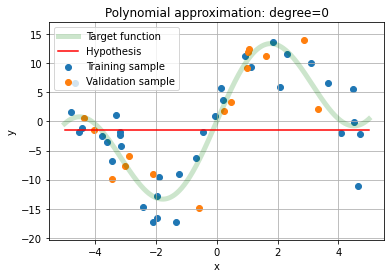

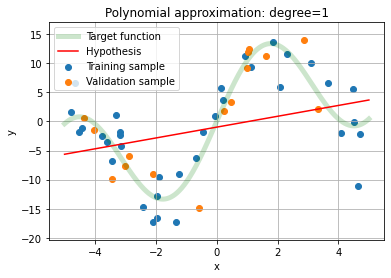

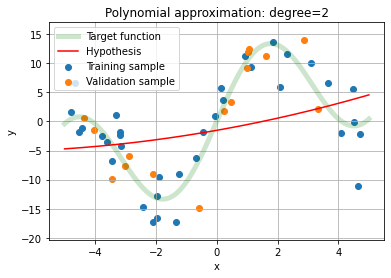

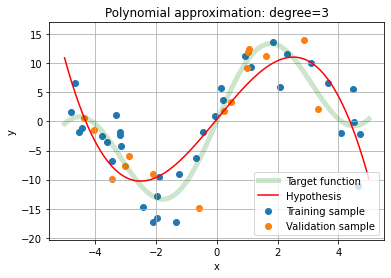

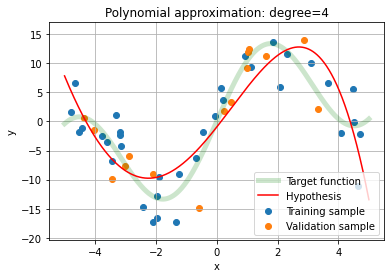

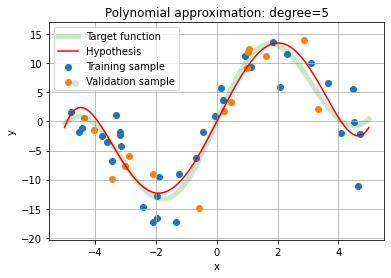

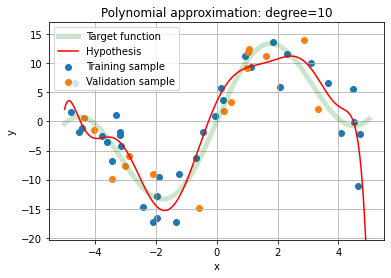

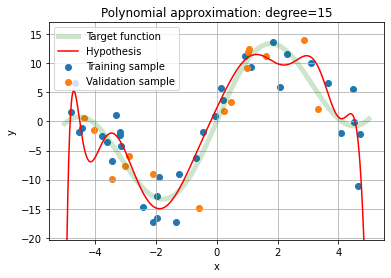

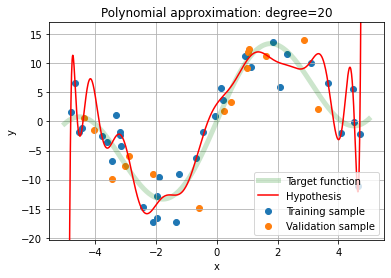

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

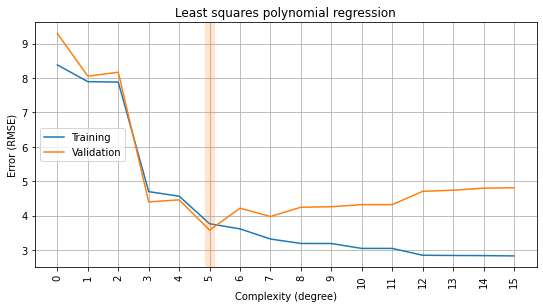

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [15]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

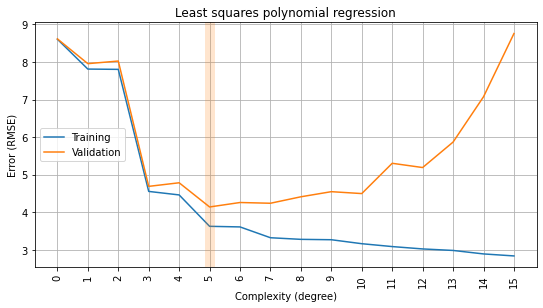

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

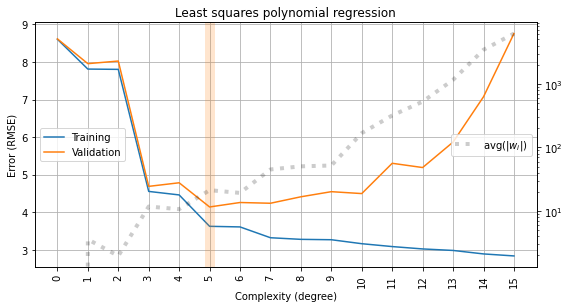

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

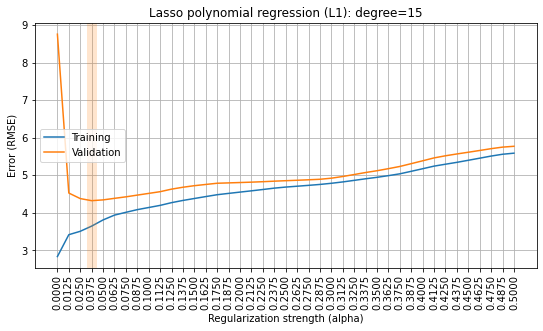

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

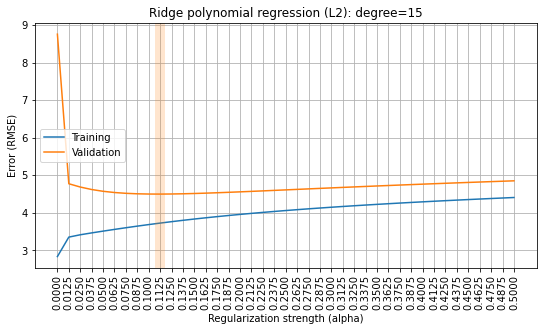

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [22]:
print("Исходные данные")
X_diabetes

Исходные данные


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


Строим первые 10 степеней, чтобы посмотреть на поведение, не затратив слишком много времени
DEGREES =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


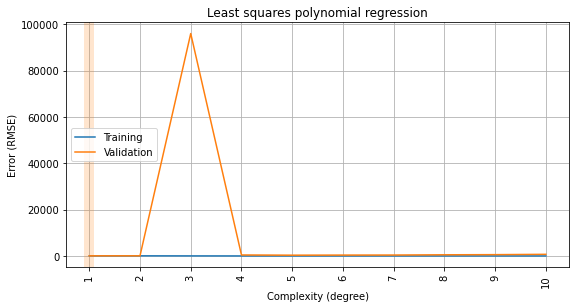

Wall time: 12.9 s


In [23]:
%%time
#Построим первые несколько степеней для предварительной оценки
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
DEGREES = [1,2,3,4,5,6,7,8,9,10]
print("Строим первые 10 степеней, чтобы посмотреть на поведение, не затратив слишком много времени")
print("DEGREES = ", DEGREES)
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Видим большую ошибку при степени degree=3 <br>
Проверим корреляцию величин, чтобы попробовать понять причину

<AxesSubplot:>

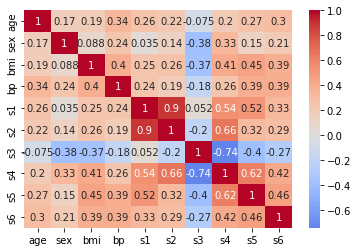

In [24]:
correlation_matrix = X_diabetes.corr()
sns.heatmap(correlation_matrix, annot=True, center=0, cmap="coolwarm")

Видим высокую корреляцию между *s1* и *s2* <br>
Объединим два этих признака в один (возьмём их среднее)

<AxesSubplot:>

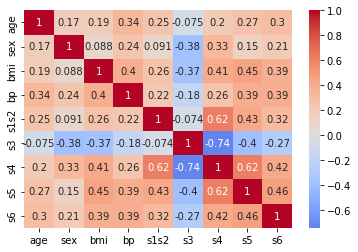

In [25]:
X_diabetes['s1s2']=(X_diabetes['s1']+X_diabetes['s2'])/2
X_diabetes.drop(columns=['s1','s2'], inplace=True)
X_diabetes = X_diabetes[["age", "sex", "bmi", "bp", "s1s2", "s3", "s4", "s5", "s6"]]
correlation_matrix = X_diabetes.corr()
sns.heatmap(correlation_matrix, annot=True, center=0, cmap="coolwarm")

Стало лучше.

**Внимание!** Не используем здесь крос-валидацию из-за существенного увеличения времени. Образец использования будет далее

Строим все 15 степеней, чтобы произвести оценку
DEGREES =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    Degree  Mean abs coef  Max abs coef  RMSE train  RMSE valid
0      1.0   1.216000e+01  2.707000e+01       54.32       53.21
1      2.0   1.136534e+13  3.068642e+14       50.74       54.54
2      3.0   7.996963e+11  3.598462e+13       32.36      131.54
3      4.0   1.864000e+01  9.296000e+01        0.00      434.52
4      5.0   5.430000e+00  2.758000e+01        0.00      331.57
5      6.0   2.400000e+00  2.187000e+01        0.00      391.13
6      7.0   1.190000e+00  1.690000e+01        0.00      392.73
7      8.0   6.300000e-01  1.568000e+01        0.00      535.14
8      9.0   3.600000e-01  1.325000e+01        0.00      562.26
9     10.0   2.100000e-01  1.266000e+01        0.00      746.22
10    11.0   1.300000e-01  1.139000e+01        0.00      895.11
11    12.0   8.000000e-02  1.124000e+01        0.00     1034.67
12    13.0   5.000000e-02  1.067000e+01        0.00     1

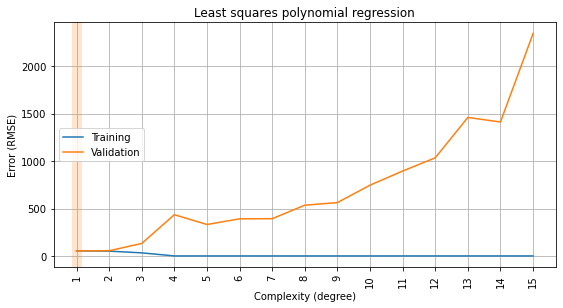

Wall time: 2min 28s


In [26]:
%%time
#Делим 70% на 30%
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
DEGREES = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
print("Строим все 15 степеней, чтобы произвести оценку")
print("DEGREES = ", DEGREES)
stat=pd.DataFrame(columns=["Degree","Mean abs coef", "Max abs coef", "RMSE train", "RMSE valid"])

for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    stat.loc[stat.shape[0]] = [degree, 
                               round(abs(reg['reg'].coef_).mean(),2),
                               round(abs(reg['reg'].coef_).max(),2),
                               round(rmse(reg.predict(X_train), y_train),2), 
                               round(rmse(reg.predict(X_valid), y_valid),2)]
print(stat)
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Скачок ошибки при degree=3 ушёл. <br>
Видим, что при увеличении степени происходит уменьшение ошибки на датасете train и увеличение ошибки на датасете valid. Это говорит о том, что происходит переобучение (*overfitting*). <br>
Также необходимо отметить, что при degree=2 и degree=3 максимальное значение коэффициентов имеет порядок $10^{12}$ и $10^{14}$, что говорит о явной неустойчивости модели и может привести к очень большому росту ошибки на некоторых данных.

Строим без degree=[1, 2, 3], чтобы оценить поведение в районе degree=1 - степени с минимальной ошибкой
DEGREES =  [1, 2, 3]


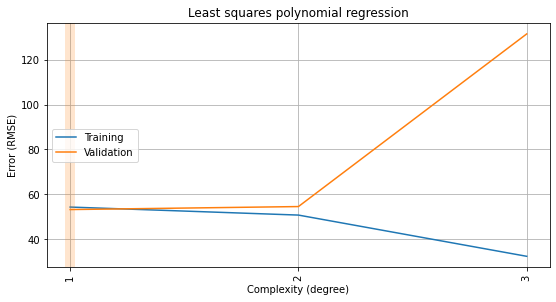

Wall time: 184 ms


In [29]:
%%time
rmse_train, rmse_valid = [], []
DEGREES = [1,2,3]
print(f"Строим без degree={DEGREES}, чтобы оценить поведение в районе degree=1 - степени с минимальной ошибкой")
print("DEGREES = ", DEGREES)
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

**<Font color="Red"> ИТОГ: </font>**
* **Degree=1** - лучшая степень для модели.
* **Degree=2** - также хорошая степень для полиномизации, так как точность модели на тренировочном датасете увеличилась, а на проверочном - незначительно уменьшилась
* **Degree>2** - overfitting, т.к. с ростом степени полинома растёт ошибка на проверочной части, а ошибка на тренировочной части уменьшается.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

*Далее будем использовать не весь датасет X_diabetes, а лишь некоторые из его параметров. Это необходимо, для того, чтобы ускорить вычисление!*

In [47]:
def plot_coef_graph(x, coef, raw_coef, xlabel, ylabel, custom_label='', custom_scale='log', title=''):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, coef, label='With regul.')
    plt.plot(x, raw_coef, label='Without regul.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')               
    plt.show()

def plot_coef_graph_single(x, coef, xlabel, ylabel, custom_label='', custom_scale='log', title=''):
    plt.figure(figsize=(12, 4.5))
    plt.plot(x, coef, label='With regul.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')               
    plt.show()
    
ALPHAS_d = np.linspace(0, 0.5, 1 + 10)

In [31]:
import warnings
warnings.filterwarnings("ignore")

#### L1

In [ ]:
%%time
#Не используем кросс-валидация из-за слишком большого времени

#ALPHAS_d = [0, 0.1, 0.2, 0.3, 0.4]
#deg=12
#avg_coef_l1, zero_coef_l1, raw_coef_l1 = [], [], []
#alpha = 0
#X, y = X_train, y_train
#results = cross_validate(make_model(degree=deg, penalty='L1', alpha=alpha), 
#                        X, y, cv=4,
#                        return_train_score=False, return_estimator=True)
#raw_coef = (np.mean([ np.mean(np.abs(model['reg'].coef_))
#                    for model in results['estimator']]))
#zero_coef_l1 = [np.mean(np.abs(model['reg'].coef_))
#                    for model in results['estimator']]
#for alpha in ALPHAS_d :    
#    print(alpha)
#    results = cross_validate(make_model(degree=deg, penalty='L1', alpha=alpha), 
#                             X, y, cv=4,
#                             return_train_score=False, return_estimator=True)
#    avg_coef_l1.append( np.mean([np.mean(np.abs(model['reg'].coef_))
#                        for model in results['estimator'] ]))
#    raw_coef_l1.append(raw_coef)

    
#plot_coef_graph(ALPHAS_d, avg_coef_l1, raw_coef_l1,
#                   xlabel='Regularization strength (alpha)', ylabel='Average absolute weight',
#                   title=f'Lasso polynomial regression (L1): degree={deg}')

In [50]:
%%time
#Считаем без кросс-валидации
ALPHAS_l1 = ALPHAS
deg = 15
features_count = 4
avg_coef_l1, coef0_l1, raw_coef_l1 = [], [], []
rmse_train_l1, rmse_valid_l1 = [],[] 
zero_count_l1, nonzero_count_l1 = [], [] 
alpha = 0
print(f"Для ускорения используем только первые {features_count} параметров из X_train")
X, y = X_train.iloc[:,:features_count], y_train
X_v, y_v = X_valid.iloc[:,:features_count],y_valid
model0 = make_model(degree=deg, penalty='L1', alpha=alpha).fit(X, y)
raw_coef = abs(model0['reg'].coef_).mean()
coef0_l1 = model0['reg'].coef_
for alpha in ALPHAS_l1 :    
    if alpha==0:
        model=model0
    else:
        model = make_model(degree=deg, penalty='L1', alpha=alpha).fit(X, y)
    mean_weight = abs(model['reg'].coef_).mean()
    avg_coef_l1.append(mean_weight)
    rmse_train_l1.append(rmse(model.predict(X), y))
    rmse_valid_l1.append(rmse(model.predict(X_v), y_v))
    raw_coef_l1.append(raw_coef)
    nonzero_count_l1.append(np.count_nonzero(model['reg'].coef_))
    zero_count_l1.append(model['reg'].coef_.size - nonzero_count_l1[-1] )
    print(f"alpha = {round(alpha,3)}, mean_weight = {round(mean_weight, 3)}") 

Для ускорения используем только первые 4 параметров из X_train
alpha = 0.0, mean_weight = 1980.409
alpha = 0.012, mean_weight = 3.792
alpha = 0.025, mean_weight = 1.939
alpha = 0.038, mean_weight = 1.21
alpha = 0.05, mean_weight = 0.891
alpha = 0.062, mean_weight = 0.651
alpha = 0.075, mean_weight = 0.512
alpha = 0.088, mean_weight = 0.428
alpha = 0.1, mean_weight = 0.371
alpha = 0.112, mean_weight = 0.329
alpha = 0.125, mean_weight = 0.298
alpha = 0.138, mean_weight = 0.276
alpha = 0.15, mean_weight = 0.258
alpha = 0.162, mean_weight = 0.241
alpha = 0.175, mean_weight = 0.229
alpha = 0.188, mean_weight = 0.216
alpha = 0.2, mean_weight = 0.204
alpha = 0.213, mean_weight = 0.194
alpha = 0.225, mean_weight = 0.184
alpha = 0.238, mean_weight = 0.175
alpha = 0.25, mean_weight = 0.167
alpha = 0.262, mean_weight = 0.16
alpha = 0.275, mean_weight = 0.154
alpha = 0.288, mean_weight = 0.149
alpha = 0.3, mean_weight = 0.143
alpha = 0.312, mean_weight = 0.138
alpha = 0.325, mean_weight = 0.134
al

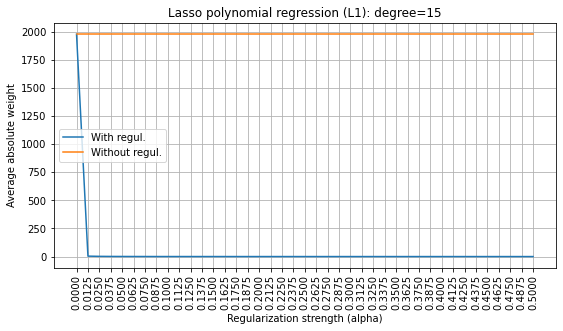

In [51]:
plot_coef_graph(ALPHAS_l1, avg_coef_l1, raw_coef_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Average absolute weight',
                   title=f'Lasso polynomial regression (L1): degree={deg}')

Поскольку при alpha=0 вес коэффициентов на три порядка больше, чем при alpha=0.1, то удалим значение при alpha=0, чтобы проанализировать поведение графика 

График без alpha=0


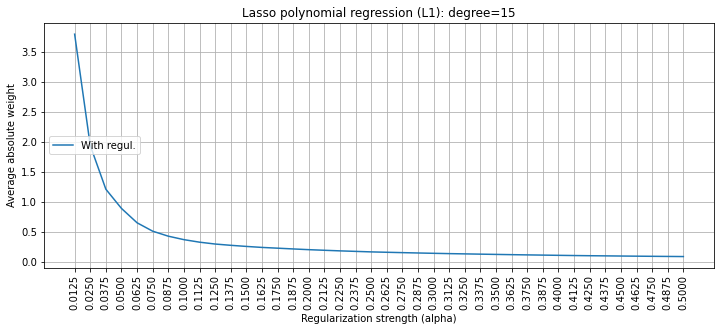

In [52]:
print("График без alpha=0")
plot_coef_graph_single(ALPHAS_l1[1:], avg_coef_l1[1:], 
                   xlabel='Regularization strength (alpha)', ylabel='Average absolute weight',
                   title=f'Lasso polynomial regression (L1): degree={deg}')

###### Далее проанализируем среднеквадратичную ошибку модели при различных alpha

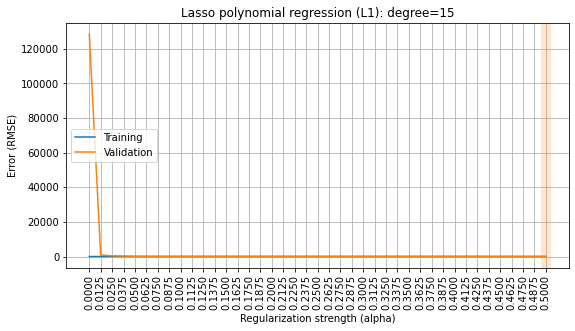

In [53]:
plot_fitting_graph(ALPHAS_l1, rmse_train_l1, rmse_valid_l1, xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title=f'Lasso polynomial regression (L1): degree={deg}')

Видим, что при alpha=0 ошибка слишком большая, поэтому для лучшего наблюдения поведения перестроим график без этой точки

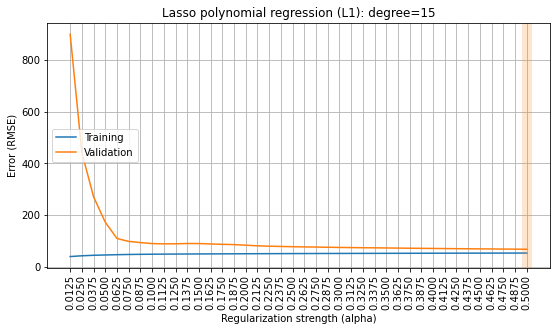

In [54]:
plot_fitting_graph(ALPHAS_l1[1:], rmse_train_l1[1:], rmse_valid_l1[1:], 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title=f'Lasso polynomial regression (L1): degree={deg}')

#### L2

Считаем без кросс-валидации. Иначе вычисления занимают слишком много времени.

In [55]:
%%time
#Считаем без кросс-валидации из-за слишком большого времени вычисления

ALPHAS_l2 = ALPHAS
deg=15
avg_coef_l2, zero_coef_l2, raw_coef_l2 = [], [], []
rmse_train_l2, rmse_valid_l2 = [],[] 
zero_count_l2, nonzero_count_l2 = [], [] 
alpha = 0
X, y = X_train, y_train
X_v, y_v = X_valid,y_valid
model0 = make_model(degree=deg, penalty='L2', alpha=alpha).fit(X, y)
raw_coef = abs(model0['reg'].coef_).mean()
zero_coef_l2 = model0['reg'].coef_
for alpha in ALPHAS_l2:
    if alpha==0:
        model=model0
    else:
        model = make_model(degree=deg, penalty='L2', alpha=alpha).fit(X, y)
    mean_weight = abs(model['reg'].coef_).mean()
    avg_coef_l2.append(mean_weight)
    raw_coef_l2.append(raw_coef)
    rmse_train_l2.append(rmse(model.predict(X), y))
    rmse_valid_l2.append(rmse(model.predict(X_v), y_v))
    nonzero_count_l2.append(np.count_nonzero(model['reg'].coef_))
    zero_count_l2.append(model['reg'].coef_.size - nonzero_count_l2[-1] )
 
    print(f"alpha = {round(alpha, 3)}, mean_weight = {round(mean_weight,3)}" )


alpha = 0.0, mean_weight = 0.025
alpha = 0.012, mean_weight = 0.025
alpha = 0.025, mean_weight = 0.025
alpha = 0.038, mean_weight = 0.025
alpha = 0.05, mean_weight = 0.025
alpha = 0.062, mean_weight = 0.025
alpha = 0.075, mean_weight = 0.025
alpha = 0.088, mean_weight = 0.025
alpha = 0.1, mean_weight = 0.025
alpha = 0.112, mean_weight = 0.025
alpha = 0.125, mean_weight = 0.024
alpha = 0.138, mean_weight = 0.024
alpha = 0.15, mean_weight = 0.024
alpha = 0.162, mean_weight = 0.024
alpha = 0.175, mean_weight = 0.024
alpha = 0.188, mean_weight = 0.024
alpha = 0.2, mean_weight = 0.024
alpha = 0.213, mean_weight = 0.024
alpha = 0.225, mean_weight = 0.024
alpha = 0.238, mean_weight = 0.024
alpha = 0.25, mean_weight = 0.024
alpha = 0.262, mean_weight = 0.024
alpha = 0.275, mean_weight = 0.024
alpha = 0.288, mean_weight = 0.024
alpha = 0.3, mean_weight = 0.024
alpha = 0.312, mean_weight = 0.024
alpha = 0.325, mean_weight = 0.024
alpha = 0.338, mean_weight = 0.024
alpha = 0.35, mean_weight = 0.0

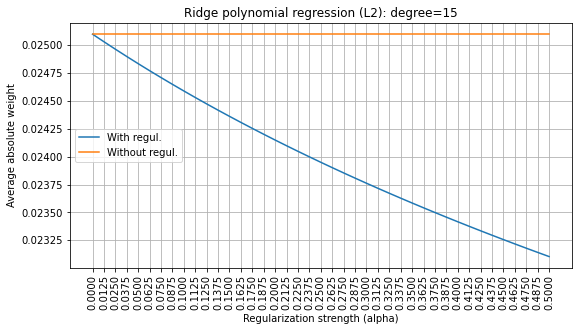

In [56]:
plot_coef_graph(ALPHAS_l2, avg_coef_l2, raw_coef_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Average absolute weight',
                   title=f'Ridge polynomial regression (L2): degree={deg}')

###### Далее проанализируем точность модели

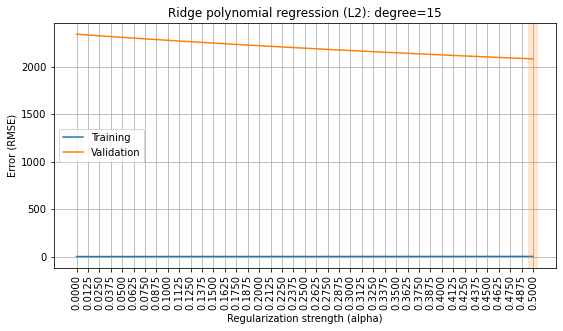

In [57]:
plot_fitting_graph(ALPHAS_l2, rmse_train_l2, rmse_valid_l2, xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title=f'Ridge polynomial regression (L2): degree={deg}')

##### Summary

##### <font color="red">Заключение </font>
**Lasso polynomial regression (L1)**
* Как и ожидалось, при введении регуляризации вес параметров снижается. 
* При этом точность предсказания даже на больших степенях полинома значительно увеличивается, и точность предсказание модели на тестовом датасете приближается к точности датасета на обучаемом датасете.
* Вес параметров снижаетсы при увеличении alpha, но это скорость изменения веса уменьшается при увеличении alpha.

**Ridge polynomial regression (L2)**
* Вес (среднее модуля коэффициентов) параметров снижается снижается незначительно. 
* Точность предсказания даже на больших степенях полинома увеличивается при увеличении силы регуляризации *alpha*.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [58]:
def plot_zerocount_graph(x, zero_count, nonzero_count, xlabel, ylabel, custom_label='', custom_scale='log', title=''):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, zero_count, label='Count zeros')
    plt.plot(x, nonzero_count, label='Count nonzeros')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')               
    plt.show()

#### L1

**Внимание!**
Вычисление количества нулевых и ненулевых коэффициентов в модели производилось в Excercise 2 при обсчёте модели для Lasso-регуляризации.
Это переменные *nonzero_count_l1* и *zero_count_l1*
 

In [59]:
l1_zeros=pd.DataFrame()
l1_zeros['Alpha'] = ALPHAS_l1
l1_zeros['Zeros count'] = zero_count_l1
l1_zeros['Nonzeros count'] = nonzero_count_l1

l1_zeros

,Alpha,Zeros count,Nonzeros count
0,0.0000,0,3875
1,0.0125,3515,360
2,0.0250,3644,231
3,0.0375,3695,180
4,0.0500,3719,156
5,0.0625,3736,139
6,0.0750,3748,127
7,0.0875,3753,122
8,0.1000,3762,113
9,0.1125,3770,105


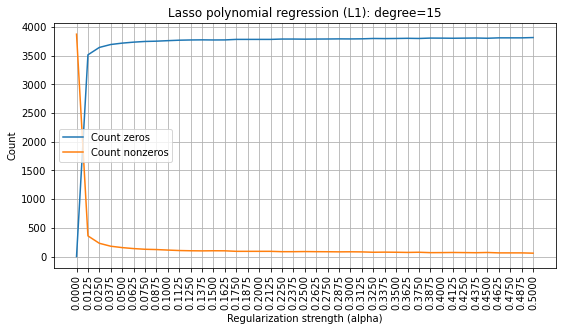

In [60]:
plot_zerocount_graph(ALPHAS_l1, zero_count_l1, nonzero_count_l1, 
                   xlabel='Regularization strength (alpha)', ylabel='Count', 
                   title=f'Lasso polynomial regression (L1): degree=15')

#### L2

**Внимание!**
Вычисление количества нулевых и ненулевых коэффициентов в модели производилось в Excercise 2 при обсчёте модели для Ridge-регуляризации.
Это переменные *nonzero_count_l2* и *zero_count_l2*

In [61]:
l2_zeros=pd.DataFrame()
l2_zeros['Alpha'] = ALPHAS_l2
l2_zeros['Zeros count'] = zero_count_l2
l2_zeros['Nonzeros count'] = nonzero_count_l2

l2_zeros

,Alpha,Zeros count,Nonzeros count
0,0.0000,0,1307503
1,0.0125,0,1307503
2,0.0250,0,1307503
3,0.0375,0,1307503
4,0.0500,0,1307503
5,0.0625,0,1307503
6,0.0750,0,1307503
7,0.0875,0,1307503
8,0.1000,0,1307503
9,0.1125,0,1307503


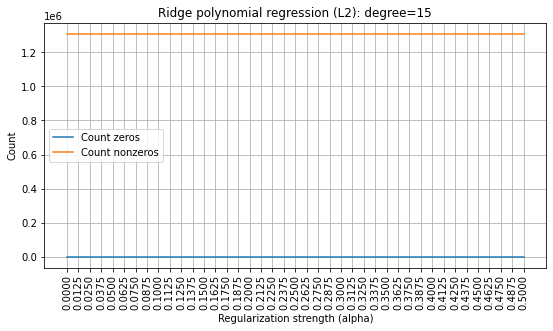

In [62]:
plot_zerocount_graph(ALPHAS_l2, zero_count_l2, nonzero_count_l2, 
                   xlabel='Regularization strength (alpha)', ylabel='Count', 
                   title=f'Ridge polynomial regression (L2): degree=15')

#### Summary

##### <font color="red">Заключение </font>
**Lasso polynomial regression (L1)**
* Как и ожидалось, для *Lasso*-регуляризации количество нулевых коэффициентов увеличивается при увеличение значения *alpha*. При этом, при число нулевых коэффициентов значительно увеличивается даже при незначительном отклонении *alpha* от нуля.

**Ridge polynomial regression (L2)**
* Нет изменения количества нулевых коэффициентов при при увеличении параметра *alpha*, что и было продемонстрировано на нашей модели.


 

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [63]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [64]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
def make_model_4(degree, alpha=0, penalty=None, scaler=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    if scaler and scaler != 'None':
        return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('sca', scaler()),
            ('reg', regressor)])
    else:
        return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('reg', regressor)])          


In [65]:
def plot_feature_graph_4(x, stats,feature,
                    xlabel, ylabel, 
                    title=''):
    plt.figure(figsize=(12, 5))
    for scaler in stats['Scaler']:
        plt.plot(x, stats[stats['Scaler'] == scaler][feature].values[0], label=scaler)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
        
    plt.show()

In [66]:
#Делим 70% на 30%
X_train_4, X_valid_4, y_train_4, y_valid_4 = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

##### ВНИМАНИЕ!  Для L1 и L2 будет рассматривать три вида скалирования: Без скалирования, StandartScaler, MinMaxScaler, RobustScaler

#### L1

In [67]:
%%time
ALPHAS_4= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
deg = 15
avg_coef_4_l1 = []
rmse_train_4_l1, rmse_valid_4_l1 = [],[] 
avg_coef_4_l1 = []
zero_count_4_l1, nonzero_count_4_l1 = [], [] 
scalers = [None,  StandardScaler, MinMaxScaler, RobustScaler]
X, y = X_train_4, y_train_4
X_v, y_v = X_valid_4,y_valid_4
i=-1
for scaler in scalers:
    print('Scaler = ', scaler)
    rmse_t, rmse_v, avg_c, nonzero_c, zero_c= [], [], [], [], [] 
    for alpha in ALPHAS_4 :    
        results = cross_validate(make_model_4(degree=deg, penalty='L1', alpha=alpha, scaler=scaler), 
                                 X, y, cv=4,
                                 return_train_score=True, return_estimator=True,
                                 scoring='neg_root_mean_squared_error')
        rmse_t.append(-np.mean(results['train_score']))
        rmse_v.append(-np.mean(results['test_score']))   
        avg_c.append( np.mean([np.mean(np.abs(model['reg'].coef_))
                            for model in results['estimator'] ]))
        nonzero_c.append(np.mean([np.count_nonzero(np.abs(model['reg'].coef_))
                                for model in results['estimator'] ]))
        zero_c.append(100*(results['estimator'][0]['reg'].coef_.size - nonzero_c[-1])/results['estimator'][0]['reg'].coef_.size)
        
    rmse_train_4_l1.append(rmse_t)
    rmse_valid_4_l1.append(rmse_v)
    avg_coef_4_l1.append(avg_c)
    nonzero_count_4_l1.append(nonzero_c)
    zero_count_4_l1.append(zero_c)

Scaler =  None
Scaler =  <class 'sklearn.preprocessing._data.StandardScaler'>
Scaler =  <class 'sklearn.preprocessing._data.MinMaxScaler'>
Scaler =  <class 'sklearn.preprocessing._data.RobustScaler'>
Wall time: 2min 25s


In [68]:
#Собираем всё в один датафрейм
stat4 = pd.DataFrame()
stat4["Scaler"] = [('None' if (sc is None) else sc.__name__) for sc in scalers]
stat4["RMSE (train)"] = rmse_train_4_l1
stat4["RMSE (valid)"] = rmse_valid_4_l1
stat4["Avg abs coef"] = avg_coef_4_l1
stat4["Zero coef. percent"] = zero_count_4_l1
stat4["Nonzero coef. count"] = nonzero_count_4_l1


###### Для исследования полученных результатов, построим графики

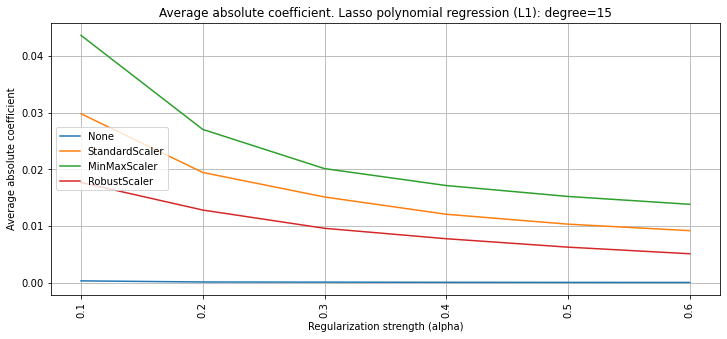

In [69]:
plot_feature_graph_4(ALPHAS_4, stats=stat4, feature='Avg abs coef',
                    xlabel="Regularization strength (alpha)", ylabel='Average absolute coefficient', 
                    title=f'Average absolute coefficient. Lasso polynomial regression (L1): degree={deg}')

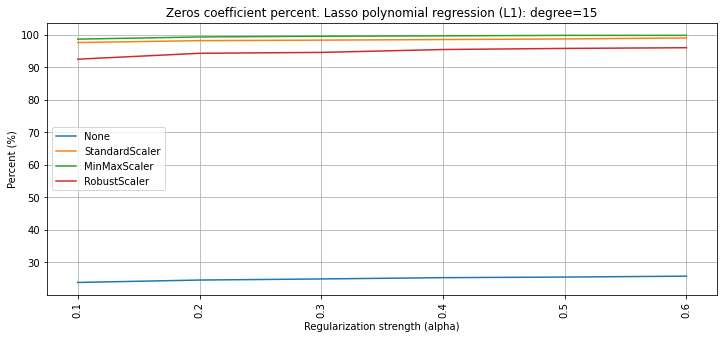

In [70]:
plot_feature_graph_4(ALPHAS_4, stats=stat4, feature='Zero coef. percent',
                    xlabel="Regularization strength (alpha)", ylabel='Percent (%)', 
                    title=f'Zeros coefficient percent. Lasso polynomial regression (L1): degree={deg}')

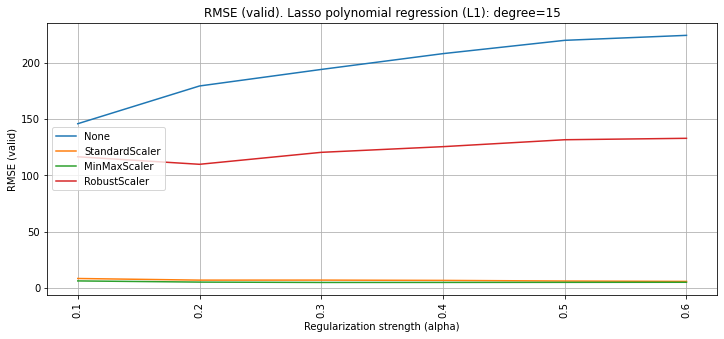

In [71]:
plot_feature_graph_4(ALPHAS_4, stats=stat4, feature='RMSE (valid)',
                    xlabel="Regularization strength (alpha)", ylabel='RMSE (valid)', 
                    title=f'RMSE (valid). Lasso polynomial regression (L1): degree={deg}')

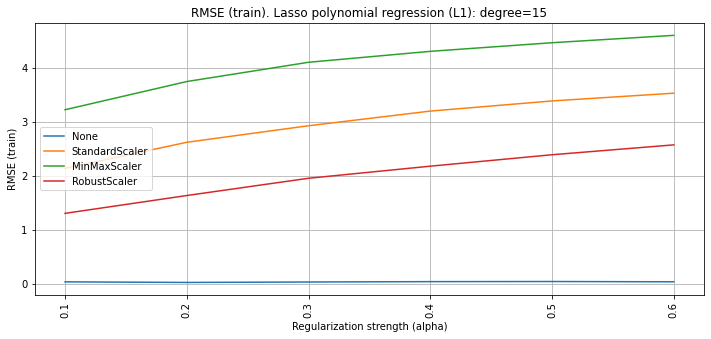

In [72]:
plot_feature_graph_4(ALPHAS_4, stats=stat4, feature='RMSE (train)',
                    xlabel="Regularization strength (alpha)", ylabel='RMSE (train)', 
                    title=f'RMSE (train). Lasso polynomial regression (L1): degree={deg}')

#### L2

In [73]:
%%time
ALPHAS_4= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
ALPHAS_4 = ALPHAS[1:] #Уберём значение alpha=0
deg = 15
avg_coef_4_l2 = []
rmse_train_4_l2, rmse_valid_4_l2 = [],[] 
avg_coef_4_l2 = []
zero_count_4_l2, nonzero_count_4_l2 = [], [] 
scalers = [None,  StandardScaler, MinMaxScaler, RobustScaler]
X, y = X_train_4, y_train_4
X_v, y_v = X_valid_4,y_valid_4
for scaler in scalers:
    print('Scaler = ', scaler)
    rmse_t, rmse_v, avg_c, nonzero_c, zero_c= [], [], [], [], [] 
    for alpha in ALPHAS_4 :    
        results = cross_validate(make_model_4(degree=deg, penalty='L2', alpha=alpha, scaler=scaler), 
                                 X, y, cv=4,
                                 return_train_score=True, return_estimator=True,
                                 scoring='neg_root_mean_squared_error')
        rmse_t.append(-np.mean(results['train_score']))
        rmse_v.append(-np.mean(results['test_score']))   
        avg_c.append( np.mean([np.mean(np.abs(model['reg'].coef_))
                            for model in results['estimator'] ]))
        nonzero_c.append(np.mean([np.count_nonzero(np.abs(model['reg'].coef_))
                                for model in results['estimator'] ]))
        zero_c.append(100*(results['estimator'][0]['reg'].coef_.size - nonzero_c[-1])/results['estimator'][0]['reg'].coef_.size)
        
    rmse_train_4_l2.append(rmse_t)
    rmse_valid_4_l2.append(rmse_v)
    avg_coef_4_l2.append(avg_c)
    nonzero_count_4_l2.append(nonzero_c)
    zero_count_4_l2.append(zero_c)

Scaler =  None
Scaler =  <class 'sklearn.preprocessing._data.StandardScaler'>
Scaler =  <class 'sklearn.preprocessing._data.MinMaxScaler'>
Scaler =  <class 'sklearn.preprocessing._data.RobustScaler'>
Wall time: 16.4 s


In [74]:
#Собираем всё в один датафрейм
stat4_2 = pd.DataFrame()
stat4_2["Scaler"] = [('None' if (sc is None) else sc.__name__) for sc in scalers]
stat4_2["RMSE (train)"] = rmse_train_4_l2
stat4_2["RMSE (valid)"] = rmse_valid_4_l2
stat4_2["Avg abs coef"] = avg_coef_4_l2
stat4_2["Zero coef. percent"] = zero_count_4_l2
stat4_2["Nonzero coef. count"] = nonzero_count_4_l2

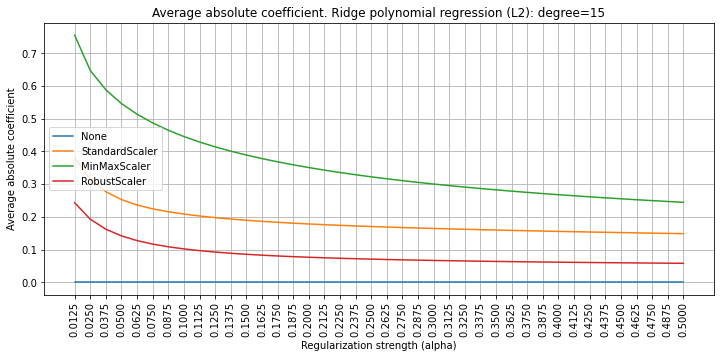

In [75]:
plot_feature_graph_4(ALPHAS_4, stats=stat4_2, feature='Avg abs coef',
                    xlabel="Regularization strength (alpha)", ylabel='Average absolute coefficient', 
                    title=f'Average absolute coefficient. Ridge polynomial regression (L2): degree={deg}')

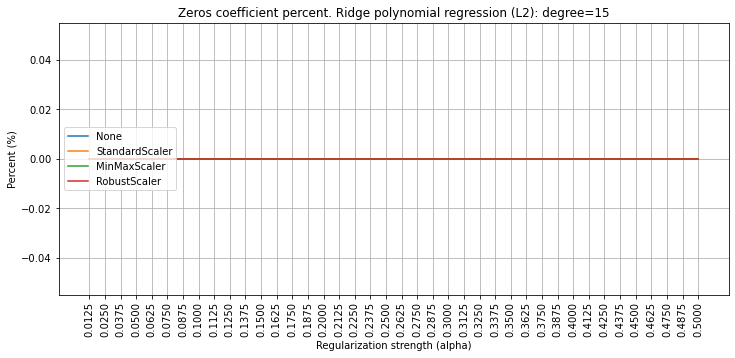

In [76]:
plot_feature_graph_4(ALPHAS_4, stats=stat4_2, feature='Zero coef. percent',
                    xlabel="Regularization strength (alpha)", ylabel='Percent (%)', 
                    title=f'Zeros coefficient percent. Ridge polynomial regression (L2): degree={deg}')

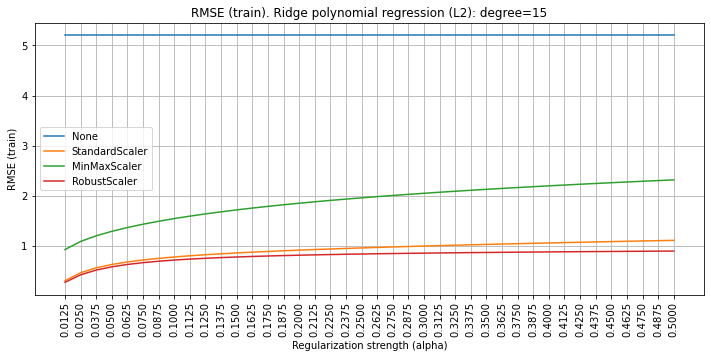

In [77]:
plot_feature_graph_4(ALPHAS_4, stats=stat4_2, feature='RMSE (train)',
                    xlabel="Regularization strength (alpha)", ylabel='RMSE (train)', 
                    title=f'RMSE (train). Ridge polynomial regression (L2): degree={deg}')

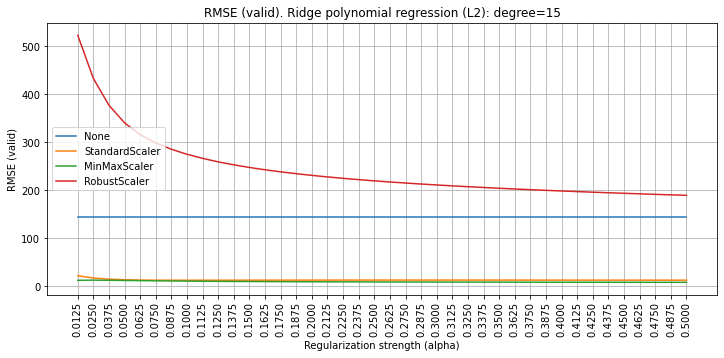

In [78]:
#Уберём alpha=0
plot_feature_graph_4(ALPHAS_4, stats=stat4_2, feature='RMSE (valid)',
                    xlabel="Regularization strength (alpha)", ylabel='RMSE (valid)', 
                    title=f'RMSE (valid). Ridge polynomial regression (L2): degree={deg}')

#### Summary



##### <font color="red">Заключение </font>
Результаты для регуляризации L1 и L2 отличаются. <br>

**L1 - Lasso polynomial regression:**
* 1. Модели без скалирования обсчитываются гораздо дольше
* 2. Скалирование увеличивает ошибку предсказания на обучаемом датасете (*RMSE(train)*)
* 2. Скалирование снижает ошибку предсказания на проверочном датасете (*RMSE(valid)*)
* 3. Скалирование увеличивает количество нулевых коэффициентов.
* 4. Существенной разницы между библиотечными функциями скалирования на итоговых результатах нет (за исключением *RobustScaler*)

<br>

**L2 - Ridge polynomial regression:**
* 1. Скалирование не оказывает заметного влияния на обсчитывание модели. 
* 2. Скалирование снижает ошибку предсказания на обучаемом датасете (*RMSE(train)*)
* 2. Скалирование (кроме *RobustScaler*) снижает ошибку предсказания на проверочном датасете ((*RMSE(valid)*))
* 3. Скалирование не изменяет количество нулевых коэффициентов.
* 4. Существенной разницы между библиотечными функциями скалирования на итоговых результатах нет (за исключением *RobustScaler*)
